In [1]:
from skimage.feature import daisy
from skimage import data
import matplotlib.pyplot as plt
from skimage.io import imread
import skimage
from skimage.feature import match_template
from skimage import measure
import cv2
import numpy as np
from matplotlib import pyplot as plt

img = cv2.imread('../resources/Sudoku16.jpg',0)
gray = cv2.medianBlur(img,5)

ret,th1 = cv2.threshold(gray,127,255,cv2.THRESH_BINARY)
th2 = cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_MEAN_C,\
            cv2.THRESH_BINARY,11,2)
th3 = cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY,11,2)

titles = ['Original Image', 'Global Thresholding (v = 127)',
            'Adaptive Mean Thresholding', 'Adaptive Gaussian Thresholding']
images = [gray, th1, th2, th3]

plt.figure(figsize=(20,20))
for i in xrange(4):
    plt.subplot(2,2,i+1),plt.imshow(images[i],'gray')
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])
plt.show()

<Figure size 2000x2000 with 4 Axes>

In [2]:
contours = measure.find_contours(th3, 0.8)
sizes = []
for i in range(len(contours)-1):
    sizes.append(len(contours[i]))

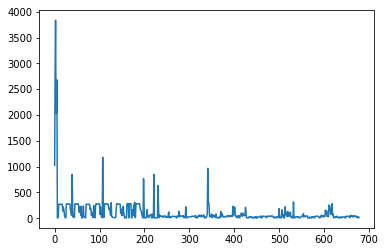

In [3]:
import numpy as np
plt.plot(sizes)

In [4]:
topblocksizes = np.sort(sizes)[-10:]
topblocks = []
for i in range(len(contours)-1):
    if len(contours[i]) in topblocksizes:
        topblocks.append(contours[i])

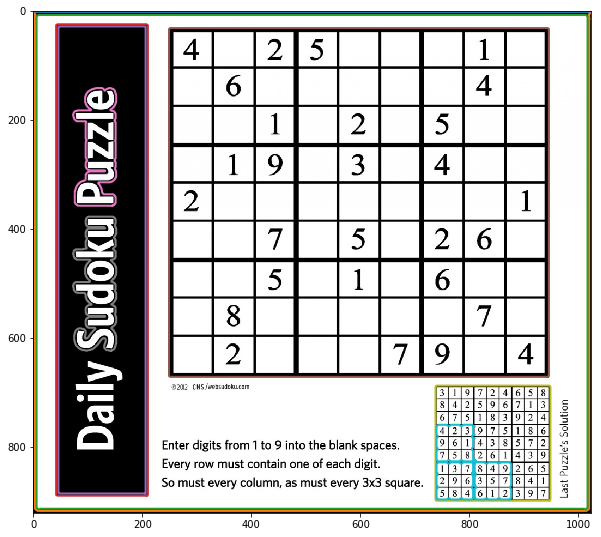

In [5]:
# Display the image and plot all contours found
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(img, interpolation='nearest', cmap=plt.cm.gray)

for n, contour in enumerate(topblocks):
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)

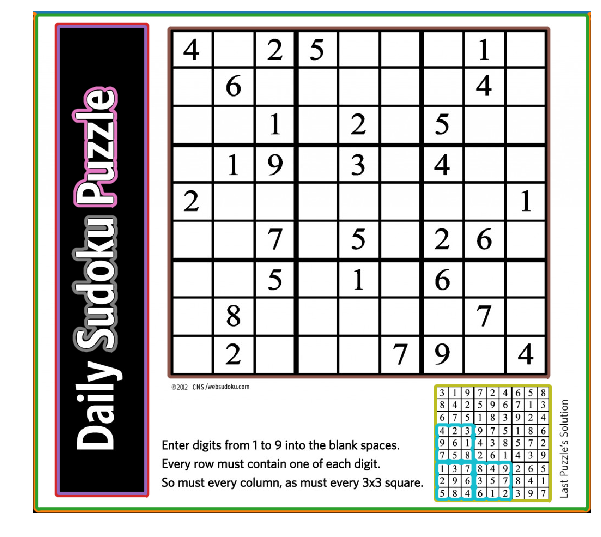

In [6]:
from skimage import transform as tf
from skimage.measure import approximate_polygon, subdivide_polygon

fig, ax = plt.subplots(figsize=(10,10))
ax.axis("off")
ax.imshow(img, cmap="gray")

polygons = []
for n, contour in enumerate(topblocks):
    polygon =  approximate_polygon(contour,0.1)
    polygons.append(polygon)
    ax.plot(polygon[:, 1], polygon[:, 0], linewidth=3)

In [10]:
import math 
from rdp import rdp
from skimage.feature import match_template
from skimage.measure import compare_mse, compare_ssim
from skimage.transform import resize
from skimage.color import rgb2gray
from skimage.filters import threshold_minimum

template = rgb2gray(resize(imread('../resources/blank-sudoku-grid.png'),(90,90)))
thresh_min = threshold_minimum(template)
template = template > thresh_min

def closest_to_point(zero, all_points):
    shortest_dist = 0
    interesting_index = 0
    for index, point in enumerate(all_points):
        dist = np.linalg.norm(zero-point)
        if shortest_dist == 0:
            shortest_dist = dist
            interesting_index = index
        elif shortest_dist > dist:
            shortest_dist = dist
            interesting_index = index

    return all_points[interesting_index]

warped_polygons = []

def extract_contour_image(polygon):

    tl = closest_to_point(np.array([0,0]), polygon)
    tr = closest_to_point(np.array([img.shape[1], 0]), polygon)
    br = closest_to_point(np.array([img.shape[1],img.shape[0]]), polygon)
    bl = closest_to_point(np.array([0,img.shape[0]]), polygon)
    
    corner_points = [tl, tr, br, bl]
    
    x = []
    y = []
    for k in corner_points:
        x.append(k[1])
        y.append(k[0])

    #find the index with the shortest distance from zero
    shortest_dist = 0
    interesting_index = 0
    zero = np.array([0,0])
    for index, point in enumerate(corner_points):
        dist = np.linalg.norm(zero-point)
        if shortest_dist == 0:
            shortest_dist = dist
            interesting_index = index
        elif shortest_dist > dist:
            shortest_dist = dist
            interesting_index = index

    src = np.array([[0, 0], [0, 900], [900, 900], [900, 0]])
    dst = np.array([[x[0],y[0]], [x[1],y[1]], [x[2],y[2]], [x[3],y[3]] ])

    tform3 = tf.ProjectiveTransform()
    tform3.estimate(src, dst)
    warped = tf.warp(img, tform3, output_shape=(900, 900))

    try:
        extracted = resize(warped,(90,90))
        thresh_min = threshold_minimum(extracted)
        extracted = extracted > thresh_min

        similarity = compare_mse(template,extracted)
        print similarity
        warped_polygons.append([similarity,polygon, warped])
    except:
        #do nothing
        print "error"
        
for polygon in polygons:
    extract_contour_image(polygon)

error
0.30444444444444446
0.33901234567901234
0.7837037037037037
0.784320987654321
0.0819753086419753
0.4685185185185185
0.44246913580246916
0.1819753086419753
0.13493827160493826


In [11]:
def render_block(index):
    polygon = warped_polygons[index][1]
    warped = warped_polygons[index][2]

    fig, ax = plt.subplots(ncols=2,figsize=(10,20))
    ax[0].imshow(img, cmap="gray")
    ax[0].plot(polygon[:, 1], polygon[:, 0], linewidth=1)
    ax[1].imshow(warped, cmap="gray")

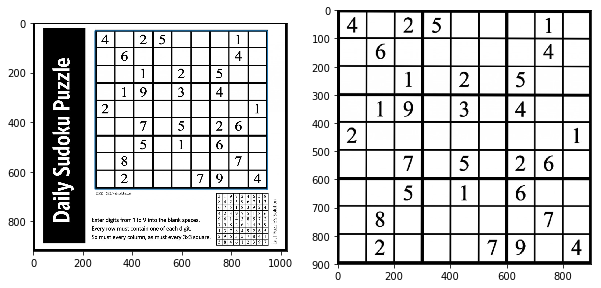

In [17]:
render_block(4)

In [13]:
len(polygons)

10